dotplot showing DEGs between early/late milo neighborhoods of WNT2 fibroblasts

# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

import os, sys, re, gc, joblib
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.sparse as sp

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap, LogNorm

import seaborn as sn

import anndata
import scanpy as sc
import sctk as sk


rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
sk.set_figsize((4, 4))
expr_cmap = sk.expression_colormap()

# Load data

In [3]:
fsk_ad = sc.read("../20210611_final_object/fetal_skin.norm.maternal_removed.20220202.h5ad")

Only considering the two last: ['.20220202', '.h5ad'].
Only considering the two last: ['.20220202', '.h5ad'].


In [4]:
early_cells = sk.read_list(
    "milo/fetal_skin.scvi_donor.milo.fig1b_annotation_vs_pcw.early_cells.list"
)
late_cells = sk.read_list("milo/fetal_skin.scvi_donor.milo.fig1b_annotation_vs_pcw.late_cells.list")

In [6]:
fsk_ad

AnnData object with n_obs × n_vars = 186533 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'fig1b_annotation_20220202'
    var: 'gene_ids', 'mit

In [7]:
fsk_ad.obs.independent_annotation_refined_20220202.cat.categories

Index(['ASDC', 'Iron-recycling macrophage', 'Adipocytes', 'Arterial', 'B cell',
       'Basal KC', 'CD4 T cell', 'CD8 T cell', 'Capillary (venular tip)',
       'Capillary/postcapillary venule', 'DC1', 'DC2', 'Dermal condensate',
       'Dermal papillia', 'Early KC (stem cell)', 'Early LE',
       'Early endothelial cell', 'Early erythroid',
       'Early erythroid (embryonic)', 'FRZB+ early fibroblast',
       'HOXC5+ early fibroblast', 'Early myocytes',
       'Eo/baso/mast cell progenitor', 'Erythroid (embryonic)',
       'Erythroid (fetal)', 'PEAR1+ fibroblast', 'WNT2+ fibroblast', 'HSC',
       'Hair follicle', 'ILC2', 'ILC3', 'Inflammatory DC', 'Innate T type1',
       'Innate T type3', 'LC', 'LE', 'LTi cell', 'Lymphoid progenitor',
       'MEMP - Early erythroid', 'MEMP - Megak', 'MHCII+ macrophage',
       'LYVE1++ macrophage', 'Mast cell (earliest)', 'Mast cell (medium)',
       'Mast cell (most mature)', 'Megakaryocyte', 'Melanoblast', 'Melanocyte',
       'TREM2+ macrophage'

In [8]:
k_wnt2 = fsk_ad.obs.independent_annotation_refined_20220202 == "WNT2+ fibroblast"
k_early = fsk_ad.obs_names.isin(early_cells)
k_late = fsk_ad.obs_names.isin(late_cells)

In [9]:
wnt2_ad = fsk_ad[k_wnt2 & (k_early | k_late)]

In [10]:
wnt2_ad

View of AnnData object with n_obs × n_vars = 16437 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'fig1b_annotation_20220202'
    var: 'gene_ids

# Process

In [11]:
wnt2_ad.obs["milo_stage"] = "Early"
wnt2_ad.obs.loc[wnt2_ad.obs_names.isin(late_cells), "milo_stage"] = "Late"
wnt2_ad.obs["milo_stage"] = wnt2_ad.obs["milo_stage"].astype(
    pd.CategoricalDtype(["Early", "Late"], ordered=True)
)

Trying to set attribute `.obs` of view, copying.


In [101]:
wnt2_ad.obs["pcw_stage"] = pd.cut(
    wnt2_ad.obs.pcw, bins=[7, 9, 12, 14, 17], right=False, include_lowest=True
)

In [102]:
wnt2_ad.obs.pcw_stage.cat.categories = wnt2_ad.obs.pcw_stage.cat.categories.astype(str)

## scanpy's DE

In [15]:
degs = sk.diffexp_paired(wnt2_ad, groupby="milo_stage", pair=["Early", "Late"], method="wilcoxon")

In [18]:
early_deg, late_deg = degs

In [24]:
early_deg1 = early_deg.loc[
    ~early_deg.genes.isin(wnt2_ad.var_names[wnt2_ad.var.ribo | wnt2_ad.var.mito])
    & (early_deg.logfoldchanges > 1)
    & (early_deg.pvals_adj < 0.05)
].sort_values(["pvals_adj", "logfoldchanges"], ascending=[True, False])

In [25]:
late_deg1 = late_deg.loc[
    ~late_deg.genes.isin(wnt2_ad.var_names[wnt2_ad.var.ribo | wnt2_ad.var.mito])
    & (late_deg.logfoldchanges > 1)
    & (late_deg.pvals_adj < 0.05)
].sort_values(["pvals_adj", "logfoldchanges"], ascending=[True, False])

In [26]:
early_deg1.head(20)

,cluster,ref,rank,genes,scores,logfoldchanges,pvals,pvals_adj
44,Early,Late,44,CCL2,58.095142,3.949052,0.0,0.0
35,Early,Late,35,DONSON,64.006927,3.848431,0.0,0.0
100,Early,Late,100,INHBA,45.408318,3.179961,0.0,0.0
93,Early,Late,93,ATF3,46.411491,2.994122,0.0,0.0
108,Early,Late,108,TAGLN,43.271980,2.958413,0.0,0.0
36,Early,Late,36,IRF1,63.233753,2.923013,0.0,0.0
24,Early,Late,24,ATP5O,71.916008,2.670044,0.0,0.0
20,Early,Late,20,TPM1,73.188675,2.644712,0.0,0.0
41,Early,Late,41,NDUFB8,59.342072,2.617155,0.0,0.0
119,Early,Late,119,HNRNPA1L2,39.844765,2.571094,0.0,0.0


In [27]:
late_deg1.head(20)

,cluster,ref,rank,genes,scores,logfoldchanges,pvals,pvals_adj
49,Late,Early,49,CLEC3B,52.871700,5.008867,0.0,0.0
2,Late,Early,2,DPT,80.845528,4.209752,0.0,0.0
87,Late,Early,87,CFD,43.787663,4.175316,0.0,0.0
108,Late,Early,108,PI16,39.563667,3.923158,0.0,0.0
73,Late,Early,73,ATP6V0C,46.982391,3.781868,0.0,0.0
5,Late,Early,5,GABARAP,77.298546,3.048984,0.0,0.0
37,Late,Early,37,MFAP5,55.508789,3.014041,0.0,0.0
17,Late,Early,17,MTRNR2L12,66.814796,3.010262,0.0,0.0
115,Late,Early,115,NRK,39.073212,2.943544,0.0,0.0
6,Late,Early,6,POSTN,76.916000,2.907179,0.0,0.0


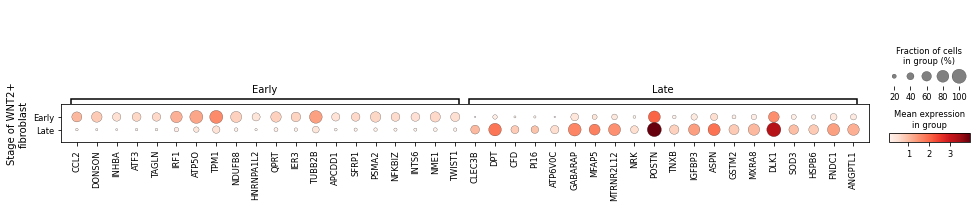

In [139]:
ax = sc.pl.dotplot(
    wnt2_ad,
    var_names={"Early": early_deg1.genes[0:20].to_list(), "Late": late_deg1.genes[0:20].to_list()},
    groupby="milo_stage",
    var_group_rotation=0,
    show=False,
)
ax["mainplot_ax"].set_ylabel("Stage of WNT2+\nfibroblast")
fig1 = ax["mainplot_ax"].get_figure()

In [103]:
sc.tl.rank_genes_groups(wnt2_ad, groupby="pcw_stage", method="wilcoxon")

In [121]:
sc.tl.filter_rank_genes_groups(
    wnt2_ad, max_out_group_fraction=0.3, min_in_group_fraction=0.5, min_fold_change=1.5
)

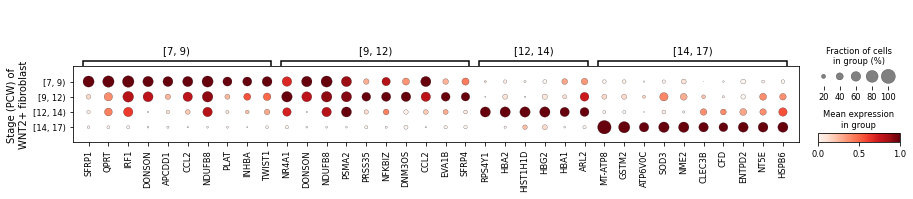

In [128]:
ax = sc.pl.rank_genes_groups_dotplot(
    wnt2_ad,
    n_genes=10,
    groupby="pcw_stage",
    dendrogram=False,
    key="rank_genes_groups_filtered",
    var_group_rotation=0,
    standard_scale="var",
    show=False,
)
ax["mainplot_ax"].set_ylabel("Stage (PCW) of\nWNT2+ fibroblast")
fig2 = ax["mainplot_ax"].get_figure()

## sctk's DE

In [59]:
mkst1 = sk.calc_marker_stats(wnt2_ad, groupby="pcw_stage")

In [60]:
mks1 = sk.filter_marker_stats(mkst1[2], max_next_frac=0.5, how="and")

In [61]:
mks1 = mks1.loc[
    ~mks1.index.isin(wnt2_ad.var_names[wnt2_ad.var.ribo | wnt2_ad.var.mito | wnt2_ad.var.hb])
]

In [62]:
mks1.groupby("top_frac_group").head(5)

,top_frac_group,top_frac,frac_diff,max_frac_diff,top_mean_group,top_mean,mean_diff,max_mean_diff
SFRP1,"[7, 9)",0.722933,0.493617,0.572429,"[7, 9)",0.284921,0.215818,0.240902
QPRT,"[7, 9)",0.747733,0.254345,0.291566,"[7, 9)",0.332629,0.167191,0.178154
APCDD1,"[7, 9)",0.624000,0.348594,0.470393,"[7, 9)",0.249933,0.161929,0.196465
CRABP1,"[7, 9)",0.818133,0.382924,0.531089,"[7, 9)",0.289255,0.160404,0.186210
FABP7,"[7, 9)",0.474400,0.395443,0.459202,"[7, 9)",0.169517,0.150767,0.165635
PRSS23,"[9, 12)",0.771062,0.271576,0.374528,"[9, 12)",0.352834,0.204006,0.261556
CTGF,"[9, 12)",0.718927,0.320801,0.374127,"[9, 12)",0.314158,0.182805,0.231522
GAS1,"[9, 12)",0.703060,0.244393,0.338436,"[9, 12)",0.294703,0.161229,0.172379
PENK,"[9, 12)",0.478655,0.358655,0.400035,"[9, 12)",0.165675,0.138183,0.143818
SEMA3A,"[9, 12)",0.451454,0.308521,0.350601,"[9, 12)",0.184605,0.135013,0.145660


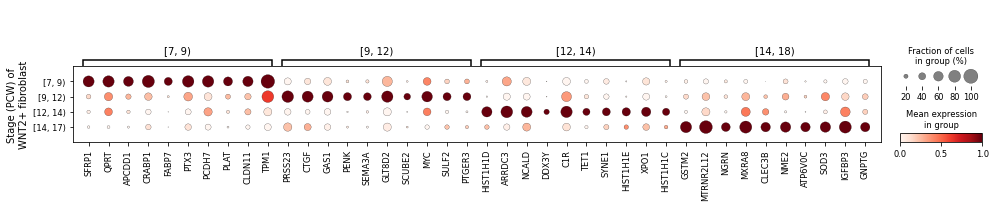

In [136]:
ax = sk.plot_markers(
    wnt2_ad,
    groupby="pcw_stage",
    mks=mks1,
    n_genes=10,
    standard_scale="var",
    var_group_rotation=0,
    show=False,
)
ax["mainplot_ax"].set_ylabel("Stage (PCW) of\nWNT2+ fibroblast")
fig4 = ax["mainplot_ax"].get_figure()

In [64]:
mkst2 = sk.calc_marker_stats(wnt2_ad, groupby="milo_stage")

In [65]:
mks2 = sk.filter_marker_stats(mkst2[2], max_next_frac=0.5, how="and")

In [68]:
mks2 = mks2.loc[
    ~mks2.index.isin(wnt2_ad.var_names[wnt2_ad.var.ribo | wnt2_ad.var.mito | wnt2_ad.var.hb])
]

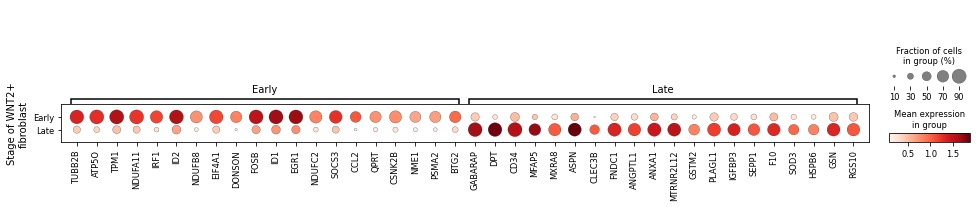

In [130]:
ax = sk.plot_markers(
    wnt2_ad, groupby="milo_stage", mks=mks2, n_genes=20, var_group_rotation=0, show=False
)
ax["mainplot_ax"].set_ylabel("Stage of WNT2+\nfibroblast")
fig3 = ax["mainplot_ax"].get_figure()

## a predined set of genes

In [91]:
genes = {
    "Biosynthetic process\nand transcriptioin": [
        "EGR1",
        "RDX",
        "RPL23",
        "SOX11",
        "TWIST1",
    ],
    "WNT Signalling": [
        "MDK",
        "SFRP1",
        "SFRP4",
        "SOSTDC1",
        "WIF1",
    ],
    "Extracellular matrix organoisation\nand collagen deposition": [
        "ADAMTS5",
        "ADAMTSL4",
        "COL1A1",
        "COL1A2",
        "COL3A1",
        "COL5A1",
        "COL6A3",
        "COL12A1",
        "COL14A1",
        "MFAP2",
        "MFAP5",
        "MMP14",
        "POSTN",
        "SPARC",
    ],
}

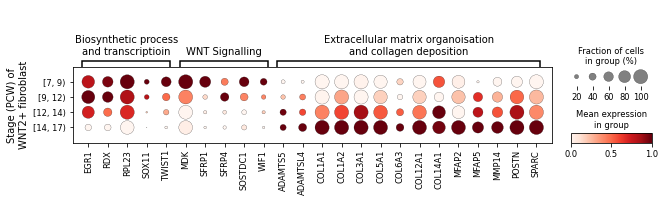

In [131]:
ax = sc.pl.dotplot(
    wnt2_ad,
    var_names=genes,
    groupby="pcw_stage",
    standard_scale="var",
    var_group_rotation=0,
    show=False,
)
ax["mainplot_ax"].set_ylabel("Stage (PCW) of\nWNT2+ fibroblast")
fig6 = ax["mainplot_ax"].get_figure()

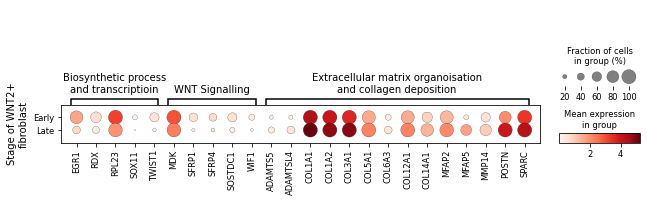

In [132]:
ax = sc.pl.dotplot(wnt2_ad, var_names=genes, groupby="milo_stage", var_group_rotation=0, show=False)
ax["mainplot_ax"].set_ylabel("Stage of WNT2+\nfibroblast")
fig5 = ax["mainplot_ax"].get_figure()

<AxesSubplot:xlabel='pcw_stage', ylabel='milo_stage'>

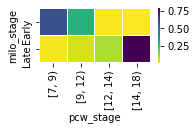

In [86]:
sk.heatmap(
    sk.cross_table(wnt2_ad, "milo_stage", "pcw_stage", normalise="jaccard"),
    cmap="viridis_r",
    figsize=(2.5, 1),
)

In [134]:
from matplotlib.backends.backend_pdf import PdfPages

In [140]:
with PdfPages(filename="fig3C_candidates.20221017.pdf") as pdf:
    pdf.savefig(fig1, bbox_inches="tight")
    pdf.savefig(fig2, bbox_inches="tight")
    pdf.savefig(fig3, bbox_inches="tight")
    pdf.savefig(fig4, bbox_inches="tight")
    pdf.savefig(fig5, bbox_inches="tight")
    pdf.savefig(fig6, bbox_inches="tight")

In [141]:
!rclone copy --drive-shared-with-me "fig3C_candidates.20221017.pdf" "google:/Fetal Skin/Figures/Figs_from_Ni/"